In [214]:
# Importing Libraries
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import matplotlib.colors as mc
from matplotlib.cm import ScalarMappable
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE

from scipy.stats import kurtosis
from scipy.stats import skew
from fitter import Fitter, get_common_distributions, get_distributions
from scipy.stats import norm
from scipy.stats import gamma
from scipy.stats import multivariate_normal

import warnings # supress warnings
warnings.filterwarnings('ignore')

## Load Dataset

In [215]:
# reading csv files
data =  pd.read_csv('E:/Data-Engineering-Jacbos/Semester 2/Statistical Modeling/Project/SeoulBikeData.csv',
                    encoding= 'unicode_escape')
data['Date'] =  pd.to_datetime(data['Date'], dayfirst= True)

In [216]:
# Count number of outliers
data[data['Rented Bike Count']>2400].count()

Date                         147
Rented Bike Count            147
Hour                         147
Temperature(°C)              147
Humidity(%)                  147
Wind speed (m/s)             147
Visibility (10m)             147
Dew point temperature(°C)    147
Solar Radiation (MJ/m2)      147
Rainfall(mm)                 147
Snowfall (cm)                147
Seasons                      147
Holiday                      147
Functioning Day              147
dtype: int64

In [217]:
# Table 2
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       8760 non-null   datetime64[ns]
 1   Rented Bike Count          8760 non-null   int64         
 2   Hour                       8760 non-null   int64         
 3   Temperature(°C)            8760 non-null   float64       
 4   Humidity(%)                8760 non-null   int64         
 5   Wind speed (m/s)           8760 non-null   float64       
 6   Visibility (10m)           8760 non-null   int64         
 7   Dew point temperature(°C)  8760 non-null   float64       
 8   Solar Radiation (MJ/m2)    8760 non-null   float64       
 9   Rainfall(mm)               8760 non-null   float64       
 10  Snowfall (cm)              8760 non-null   float64       
 11  Seasons                    8760 non-null   object        
 12  Holida

## Data Exploration

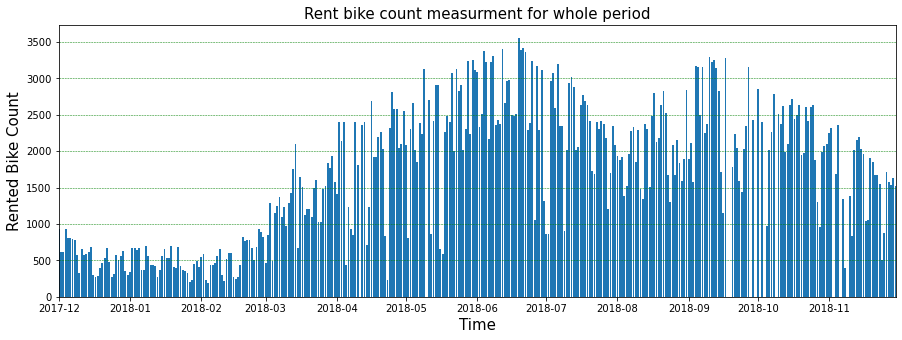

In [218]:
# Figure 2
# Plot Rented Bike Count for whole period
num_bins = 50
fig, ax = plt.subplots(figsize=(15,5))

ax.bar(data['Date'], data["Rented Bike Count"])
  
ax.set_title('Rent bike count measurment for whole period', fontsize = 15)
ax.set_ylabel('Rented Bike Count', fontsize = 15)
ax.set_xlabel('Time', fontsize = 15)
ax.grid(axis='y', color = 'green', linestyle = '--', linewidth = 0.5)
ax.set_xlim([min(data['Date']), max(data['Date'])])
plt.show()

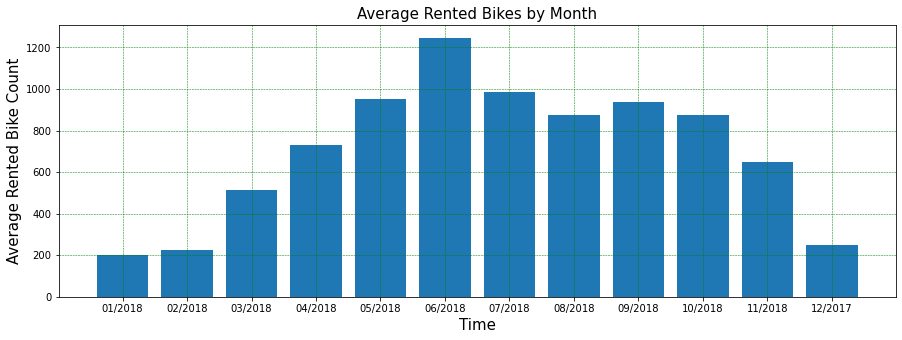

In [219]:
# Figure 3
# Plot Average Rented Bike for each month
selected_columns = data.loc [:,("Date","Rented Bike Count")]
selected_columns['Date'] = selected_columns['Date'].dt.strftime('%m/%Y')
selected_columns_g = selected_columns.groupby ('Date').mean()

fig, ax = plt.subplots(figsize=(15,5))

ax.bar(selected_columns_g.index, selected_columns_g["Rented Bike Count"])
  
ax.set_title('Average Rented Bikes by Month', fontsize = 15)
ax.set_ylabel('Average Rented Bike Count', fontsize = 15)
ax.set_xlabel('Time', fontsize = 15)
ax.grid(color = 'green', linestyle = '--', linewidth = 0.5)
plt.show()

In [ ]:
# Figure 4
# Plot Heat map of Rented Bike Count for whole period
data1 = data
data1['Date'] =  pd.to_datetime(data1['Date'], dayfirst= True)
data1 = data1.set_index('Date')


data1.index += pd.TimedeltaIndex(data1['Hour'], unit='h')
MIN_WS = data1['Rented Bike Count'].min() #edit!!
MAX_WS = data1['Rented Bike Count'].max() #edit!!

# Plotting heatmap for whole period
def single_plot (data, month, ax):
    data = data[data.index.month == month]
    hour = data.index.hour
    day = data.index.day
    WindSpeed = data['Rented Bike Count']
    #WindSpeed = WindSpeed.values.reshape(24, len(day.unique()), order="F")
    d = {'hour':hour, 'day':day, 'windspeed':WindSpeed}
    df = pd.DataFrame (data=d)
    WindSpeed = df.pivot_table(index="hour",columns="day",values="windspeed", aggfunc="mean")

    xgrid = np.arange(day.max() + 1) + 1
    ygrid = np.arange(25)
    
    ax.pcolormesh(xgrid, ygrid, WindSpeed, cmap="viridis", vmin=MIN_WS, vmax=MAX_WS)
    # Invert the vertical axis
    ax.set_ylim(24, 0)
    # Set tick positions for both axes
    ax.yaxis.set_ticks([i for i in range(24)])
    ax.xaxis.set_ticks([10, 20, 30])
    # Remove ticks by setting their length to 0
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    
    # Remove all spines
    ax.set_frame_on(False)
    

fig, axes = plt.subplots(1, 12, figsize=(14, 5), sharey=True)

single_plot(data1, 12, axes[0])
for i in range(1,12):
    single_plot(data1, i, axes[i])
    
fig.subplots_adjust(left=0.05, right=0.98, top=0.9, hspace=0.08, wspace=0.04)



# Make some room for the legend in the bottom.
fig.subplots_adjust(bottom=0.15)

# Create a new axis to contain the color bar
cbar_ax = fig.add_axes([0.3, 0.005, 0.4, 0.025])

# Create a normalizer that goes from minimum to maximum wind speed
norm = mc.Normalize(MIN_WS, MAX_WS)

# Create the colorbar and set it to horizontal
cb = fig.colorbar(
    ScalarMappable(norm=norm, cmap="viridis"), 
    cax=cbar_ax, # Pass the new axis
    orientation = "horizontal"
)

# Remove tick marks
cb.ax.xaxis.set_tick_params(size=0)

# Set legend label
cb.set_label("Rented Bike", size=12)
#fig

# Set common labels for x and y axes
fig.text(0.5, 0.08, "Day", ha="center", va="center", fontsize=14)
fig.text(0.02, 0.5, 'Hour', ha="center", va="center", rotation="vertical", fontsize=14)

fig.suptitle("Hourly Rented Bike", fontsize=20, y=0.97)
fig

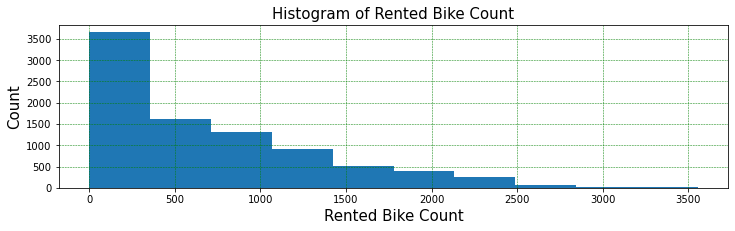

In [220]:
# Figure 5
# Plot histogram for Rented Bike Count
fig, ax = plt.subplots(figsize=(12,3))

ax.hist(data ["Rented Bike Count"])
  
ax.set_title('Histogram of Rented Bike Count',fontsize = 15)
ax.set_xlabel('Rented Bike Count', fontsize = 15)
ax.set_ylabel('Count', fontsize = 15)
ax.grid(color = 'green', linestyle = '--', linewidth = 0.5)
plt.show()

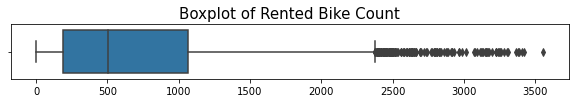

In [221]:
# Figure 6
# Plot Boxplot for Rented Bike Count
fig, ax = plt.subplots(figsize=(10,1))
sns.boxplot(data=data,x=data["Rented Bike Count"])
plt.title("Boxplot of Rented Bike Count", fontsize = 15)
ax.set_xlabel('')
plt.show()

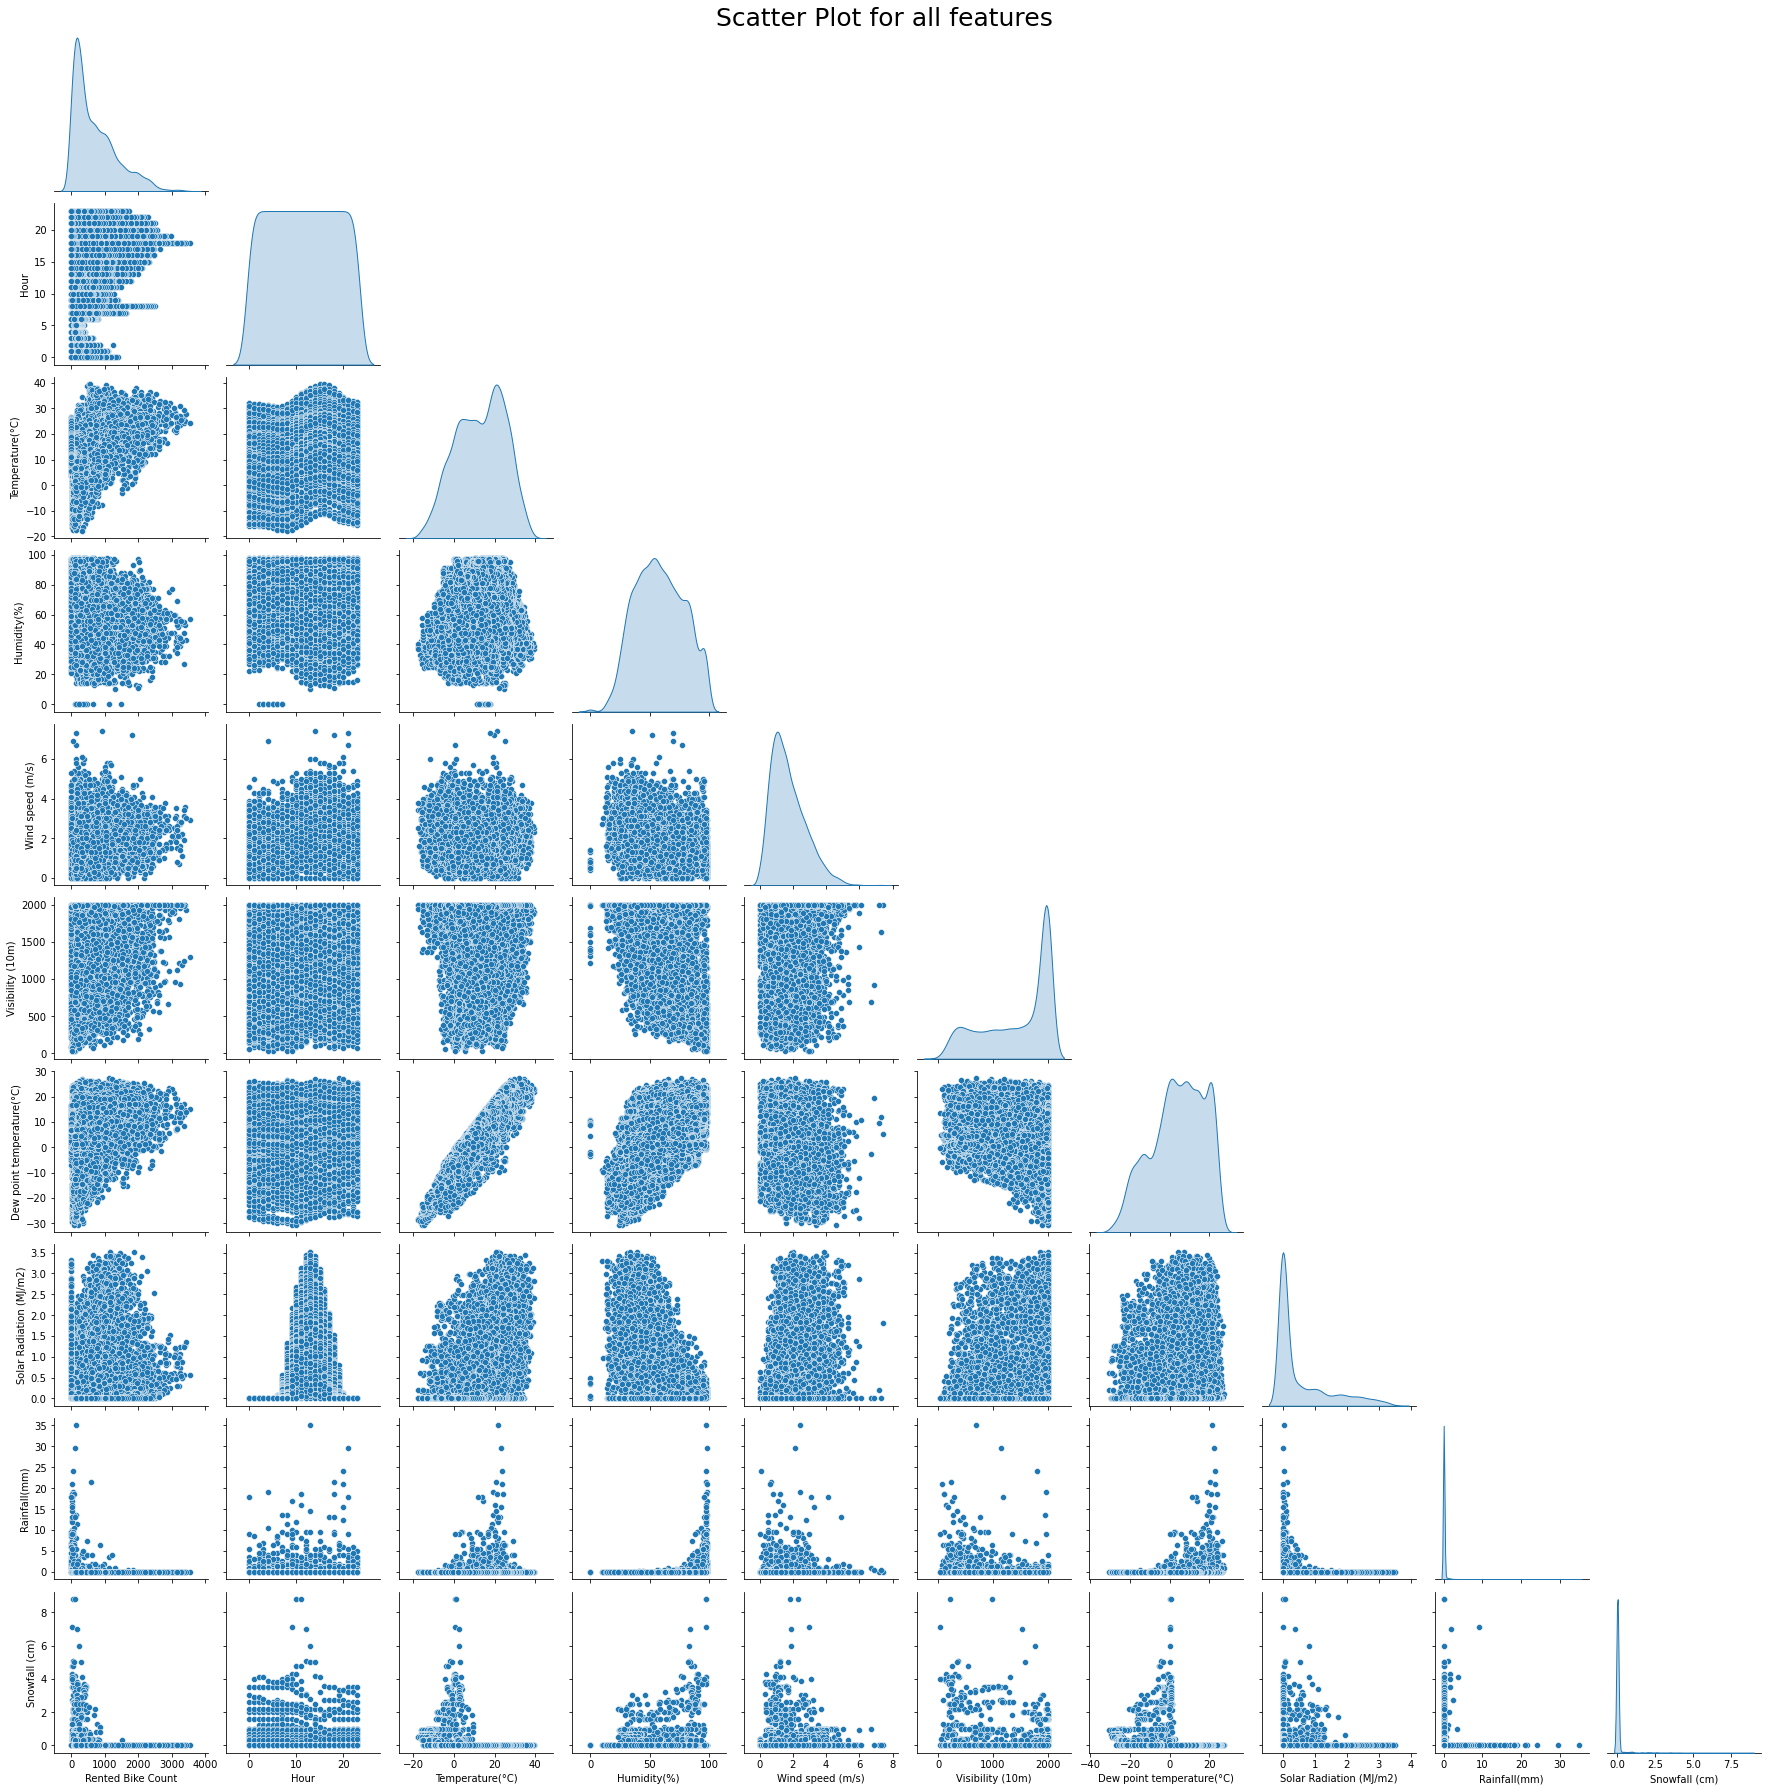

In [222]:
# Figure 7
# Scatter plot for all features

sns.pairplot(data, diag_kind='kde', corner=True)
plt.suptitle('Scatter Plot for all features', y = 1, fontsize = 25)
plt.show()

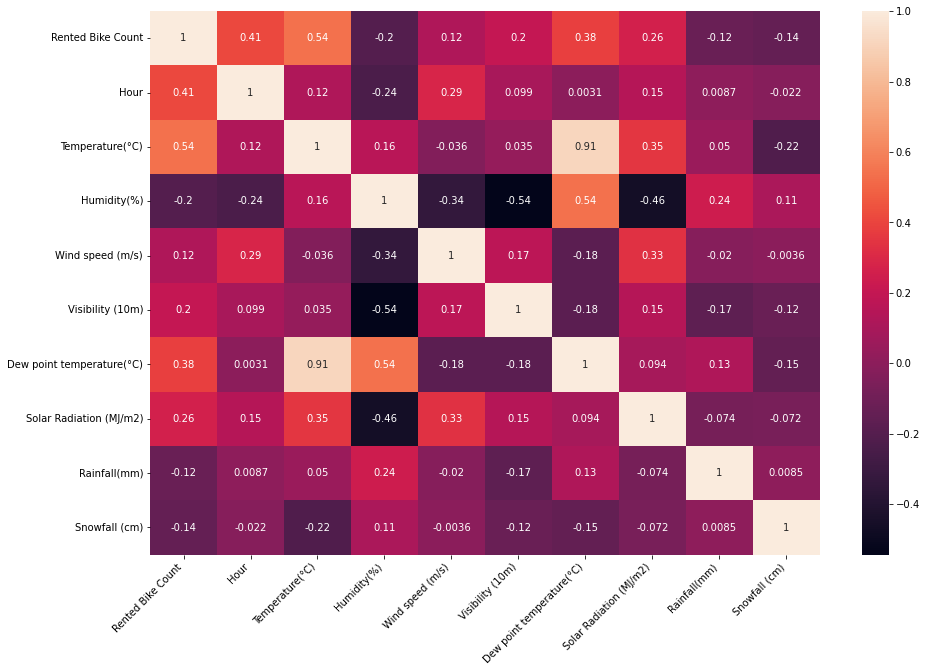

In [223]:
# Figure 8
# Correlation Matrix heatmap based on Pearson method

corrMatrix = data.corr(method='pearson')
fig, ax = plt.subplots(figsize=(15,10))
corrChart = sns.heatmap(corrMatrix, annot=True)
corrChart.set_xticklabels(corrChart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

## Temperature and Wind Speed Data

### Temperature

In [ ]:
# Figure 9
# Plot histogram and pmf for Temperature data

num_bins = 20
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.hist(data ["Temperature(°C)"],bins=num_bins)
  
ax1.set_title('Histogram of Temperature(°C)')
ax1.set_xlabel('Temperature(°C)')
ax1.set_ylabel('Count')
ax1.grid(color = 'green', linestyle = '--', linewidth = 0.5)

counts , bins = np.histogram(data ["Temperature(°C)"],bins=num_bins)
bins = bins[:-1] + (bins[1] - bins[0])/2
probs = counts/float(counts.sum())
#print (probs.sum()) # 1.0
ax2.stem(bins, probs)
ax2.set_title('pmf')
ax2.set_xlabel('Temperature(°C)')
ax2.set_ylabel('Probability')
ax2.set_ylim(bottom=0)
ax2.grid(color = 'green', linestyle = '--', linewidth = 0.5)

plt.subplots_adjust(wspace=0.5)
plt.show()

In [ ]:
# Table 3
# Calculate distribution properties for Temperature data

kur = kurtosis(data['Temperature(°C)'])
skw = skew(data['Temperature(°C)'])
std = np.std(data['Temperature(°C)'])
mean = np.mean(data['Temperature(°C)'])

print ('Mean =',round(mean,3))
print ('Standard deviation =',round(std,3))
print ('Kurtosis =', round(kur,3))
print ('Skewness =',round(skw,3))

In [ ]:
# Figure 11.a
# Fit distribution functions to the Temperature data

f = Fitter(data['Temperature(°C)'],
           distributions= get_common_distributions(),
          timeout=60)
f.fit()
f.summary()

In [ ]:
# Table 3
# Caculate distribution properties of Normal distribution

mean, var, skw, kurt = norm.stats(f.fitted_param['norm'][0],f.fitted_param['norm'][1],moments='mvsk')
print('Mean =',np.around(mean, decimals = 3))
print('Standard deviation =', np.around(math.sqrt(var), decimals = 3))
print('Skewness =', skw)
print ('Kurtosis =', kurt)

###  Wind Speed

In [ ]:
# Figure 10
# Plot histogram and pmf for Temperature data

num_bins = 20
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.hist(data ["Wind speed (m/s)"],bins=num_bins)
  
ax1.set_title('Histogram of Wind speed (m/s)')
ax1.set_xlabel('Wind speed (m/s)')
ax1.set_ylabel('Count')
ax1.grid(color = 'green', linestyle = '--', linewidth = 0.5)

counts , bins = np.histogram(data ["Wind speed (m/s)"],bins=num_bins)
bins = bins[:-1] + (bins[1] - bins[0])/2
probs = counts/float(counts.sum())
#print (probs.sum()) # 1.0
ax2.stem(bins, probs)
ax2.set_title('pmf')
ax2.set_xlabel('Wind speed (m/s)')
ax2.set_ylabel('Probability')
ax2.set_ylim(bottom=0)
ax2.grid(color = 'green', linestyle = '--', linewidth = 0.5)

plt.subplots_adjust(wspace=0.5)
plt.show()

In [ ]:
# Table 3
# Calculate distribution properties for Wind Speed data

kur = kurtosis(data['Wind speed (m/s)'])
skw = skew(data['Wind speed (m/s)'])
std = np.std(data['Wind speed (m/s)'])
mean = np.mean(data['Wind speed (m/s)'])

print ('Mean =',round(mean,3))
print ('Standard deviation =',round(std,3))
print ('Kurtosis =', round(kur,3))
print ('Skewness =',round(skw,3))

In [ ]:
# Figure 11.b
# Fit distribution functions to the Wind Speed data

f = Fitter(data['Wind speed (m/s)'],
           distributions= get_common_distributions(),
          timeout=60)
f.fit()
f.summary()

In [ ]:
# Table 3
# Caculate distribution properties of Gamma distribution

mean, var, skw, kurt = gamma.stats(f.fitted_param['gamma'][0],f.fitted_param['gamma'][1],f.fitted_param['gamma'][2]
                                    , moments='mvsk')
print('Mean =', np.around(mean, decimals = 3))
print('Standard deviation =', np.around(math.sqrt(var), decimals = 3))
print('Skewness =', np.around(skw, decimals = 3))
print ('Kurtosis =', np.around(kurt, decimals = 3))

### Joint Probability

In [ ]:
# Calculate joint pmf for Temperature and Wind Speed
    # Round the temperature and wind speed to map on the a discrete S with interval width d=1
    
t = np.array(round(data['Temperature(°C)']), dtype=object)
w = np.array(round(data['Wind speed (m/s)']), dtype=object)

# Build crosstab to find the frequency of each temperature and wind speed measurement 
cnt = pd.crosstab(t, w, rownames=['Temperature(°C)'], colnames=['Wind speed (m/s)'])
# Calculate probability based on frequency
cnt = cnt / cnt.values.sum()

#cnt

In [ ]:
# Equation 9
# Caculate Covariance Matrix
m = np.array([data['Wind speed (m/s)'],data['Temperature(°C)']])
#m
arr_cov = np.cov(m)
print ('Covariance Matrix: \n', np.around(arr_cov,3))


In [ ]:
# Equation 10
# Calculate mean
arr_mean = np.array([data['Wind speed (m/s)'].mean(),data['Temperature(°C)'].mean()])
print ('Means Array: \n', arr_mean)
print ('\nMean for Wind Speed =', round(arr_mean[0],3))
print ('Means for Temperature =', round(arr_mean[1],3))

In [ ]:
# Figure 13
# Generating a Gaussian bivariate distribution
# with given mean and covariance matrix
random_seed=1000

mean = arr_mean
cov = arr_cov
distr = multivariate_normal(cov = cov, mean = mean, seed = random_seed)
     
# Generating a meshgrid complacent with
mean_1, mean_2 = mean[0], mean[1]
sigma_1, sigma_2 = cov[0,0], cov[1,1]
     

x = np.linspace(0,7,200)
y = np.linspace(-18,39,200)

X, Y = np.meshgrid(x,y)

x1 = np.linspace(0,7,8)
y1 = np.linspace(-18,39,58)
X1, Y1 = np.meshgrid(x1,y1)

     
    # Generating the density function
    # for each point in the meshgrid
pdf = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        pdf[i,j] = distr.pdf([X[i,j], Y[i,j]])
     

fig, ax = plt.subplots(figsize=(15,10),subplot_kw={"projection": "3d"})

ax.plot_surface(X1, Y1, cnt,cmap='viridis',linewidth=0,antialiased=False)
ax.plot_wireframe(X, Y, pdf, rstride=10, cstride=10)

ax.set_xlabel('Wind Speed(m/s)', fontsize = 17)
ax.set_ylabel('Temperature(°C)', fontsize = 17)
ax.set_zlabel('Probability', fontsize = 17)

#ax.elev = 30
#ax.azim = 70

plt.show()

### Marginal and conditional probability

In [ ]:
# Calculate marginal distributions
marginal_wind = []
marginal_temp = []

for i in range(0,8):
    marginal_wind.append(cnt[i].sum())

for i in range(-18,40):
    marginal_temp.append(cnt.loc[i,:].sum())

In [ ]:
cnt_resin = cnt.reset_index(drop=True)
#cnt_resin

In [ ]:
# Figure 12
# Calculate conditional probability for temperature conditioned by wind speed = 3

con_t_w3 = cnt_resin.loc[:,3]/marginal_wind[3]
#con_t_w3

# Plotting marginal and conditional density
    # temperature marginal compared with temperature conditioned by wind speed = 3
T = np.linspace(-18,39,58)

plt.figure(figsize=(9, 6))
sns.kdeplot(data['Temperature(°C)'])
#plt.stem(T, con_t_w3, linefmt='orange', markerfmt='orange', basefmt='orange')
plt.bar(T,con_t_w3, color='orange')
plt.legend(['marginal', 'conditional'])
plt.title('Marginal and Conditional probability for Temperature and Temperature conditioned by Wind Speed = 3')

## Prediction

### Data preparation

In [ ]:
# Divide dataset into dependent and independent variables
X = data.drop (columns = ['Date' , 'Rented Bike Count'])
Y = data['Rented Bike Count']

In [ ]:
# Convert categorical variables into dummy variables
X = pd.get_dummies(X)
# n-1 variables sufficient for each categorical feature
X = X.drop (columns = ['Dew point temperature(°C)','Seasons_Spring','Holiday_No Holiday','Functioning Day_No'])

In [ ]:
# Split data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.25, random_state=13
)

### Linear Regression

In [ ]:
# step-1: create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# step-2: specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, 14))}]


# step-3: perform grid search
# 3.1 specify model
lm = LinearRegression()
lm.fit(x_train, y_train)
rfe = RFE(lm)             

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(x_train, y_train)

In [ ]:
cv_results = pd.DataFrame(model_cv.cv_results_)

In [ ]:
# Figure 14
# Plot cv results

plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features',fontsize=16)
plt.ylabel('Rsquared Score',fontsize=16)
plt.title("Optimal Number of Features", fontsize=18, fontweight ='bold')
plt.legend(['test score', 'train score'], loc='upper left')

In [ ]:
# final model
n_features_optimal = 12

lm = LinearRegression()
lm.fit(x_train, y_train)

rfe = RFE(lm, n_features_to_select=n_features_optimal)             
rfe = rfe.fit(x_train, y_train)

In [ ]:
# Table 4
# Calculate evaluation metrics for LR on test set 

rmse_lr = np.sqrt(mean_squared_error(y_test, lm.predict(x_test)))
y_pred =  lm.predict(x_test)

print("The Rsquared on test set: {:.4f}".format(lm.score(x_test, y_test)))
print("The Root Mean Squared Error (RMSE) on test set: {:.4f}".format(rmse_lr))
print("The Mean Absolute Error (MAE) on test set: {:.4f}".format(mean_absolute_error(y_test, y_pred)))

In [ ]:
# Table 4
# Calculate evaluation metrics for LR on training set 

rmse_lr = np.sqrt(mean_squared_error(y_train, lm.predict(x_train)))
y_pred =  lm.predict(x_train)

print("The Rsquared on train set: {:.4f}".format(lm.score(x_train, y_train)))
print("The Root Mean Squared Error (RMSE) on train set: {:.4f}".format(rmse_lr))
print("The Mean Absolute Error (MAE) on train set: {:.4f}".format(mean_absolute_error(y_train, y_pred)))

In [ ]:
# Figure 15
# Plot Residuals

y_pred =  lm.predict(x_test)
residuals = y_test - y_pred

fig = plt.figure(figsize=(12, 8))
plt.plot(y_test,residuals, 'o', color='orange')
plt.plot(y_test, [0]*len(y_test))
plt.title("Residual Plot", fontsize=18, fontweight ='bold')
plt.xlabel("Rented Bike Count", fontsize=16)
plt.ylabel("Residual", fontsize=16)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.show()

In [ ]:
# Figure 18
# Plot Permutation importance for LR

result = permutation_importance(lm, x_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

sorted_idx = result.importances_mean.argsort()

fig = plt.figure(figsize=(12, 10))
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(X.columns)[sorted_idx]
)
plt.title("LR Permutation Importance (test set)", fontsize=18, fontweight ='bold')
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()

### Gradient Boosting Machine

In [ ]:
# Search for the best value of learning_rate and n_estimators parameters

p_test1 = {'learning_rate':[0.01,0.005,0.001], 
           'n_estimators':[100,250,500,750,1000,1250,1500,1750,2000,2500,3000]}

tuning1 = GridSearchCV(estimator =GradientBoostingRegressor(
    max_depth=4, min_samples_split=2, loss="squared_error", random_state=10), 
            param_grid = p_test1, scoring='r2',n_jobs=4, cv=5)

tuning1.fit(x_train,y_train)
tuning1.best_params_

In [ ]:
# Figure 16
# Define a function to plot the results of Grid Search
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1,figsize=(12, 8))

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Rsquared Score', fontsize=16)
    ax.legend(loc="best", fontsize=14)
    plt.yticks(fontsize=13)
    plt.xticks(fontsize=13)
    ax.grid('on')

# Calling Method 
plot_grid_search(tuning1.cv_results_, p_test1['n_estimators'], p_test1['learning_rate'], 'N Estimators', 'Learnin Rate')

In [ ]:
p_test2 = {'max_depth':[2,3,4,5,6,7,8,9,10,11,12,13,14] }

tuning2 = GridSearchCV(estimator =GradientBoostingRegressor(
    learning_rate=0.01,n_estimators=2500, min_samples_split=2,loss="squared_error", random_state=10), 
            param_grid = p_test2, scoring='r2',n_jobs=4, cv=5)
tuning2.fit(x_train,y_train)
tuning2.best_params_

In [ ]:
# Figure 17
name_param_1 = 'Max Depth'
cv_results = tuning2.cv_results_

# Get Test Scores Mean and std for each grid search
scores_mean = cv_results['mean_test_score']
#scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

scores_sd = cv_results['std_test_score']
#scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

# Plot Grid search scores
_, ax = plt.subplots(1,1,figsize=(10, 6))

# Param1 is the X-axis, Param 2 is represented as a different curve (color line)
#for idx, val in enumerate(grid_param_2):
#    ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))
ax.plot(p_test2['max_depth'], scores_mean, '-o')

ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
ax.set_xlabel(name_param_1, fontsize=16)
ax.set_ylabel('CV Rsquared Score', fontsize=16)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
ax.grid('on')

In [ ]:
# Fit a GBM model with optimized parameters
params = {
    "n_estimators": 2500,
    "max_depth": 5,
    "min_samples_split": 2,
    "learning_rate": 0.01,
    "loss": "squared_error",
    "random_state": 10
}

reg = GradientBoostingRegressor(**params)
reg.fit(x_train, y_train)

In [ ]:
# Table 4
# Calculate evaluation metrics on test set 
rmse = np.sqrt(mean_squared_error(y_test, reg.predict(x_test)))
y_pred =  reg.predict(x_test)

print("The Rsquared on test set: {:.4f}".format(reg.score(x_test, y_test)))
print("The Root Mean Squared Error (RMSE) on test set: {:.4f}".format(rmse))
print("The Mean Absolute Error (MAE) on test set: {:.4f}".format(mean_absolute_error(y_test, y_pred)))

In [ ]:
# Table 4
# Calculate evaluation metrics on training set 
rmse = np.sqrt(mean_squared_error(y_train, reg.predict(x_train)))
y_pred =  reg.predict(x_train)

print("The Rsquared on training set: {:.4f}".format(reg.score(x_train, y_train)))
print("The Root Mean Squared Error (RMSE) on training set: {:.4f}".format(rmse))
print("The Mean Absolute Error (MAE) on training set: {:.4f}".format(mean_absolute_error(y_train, y_pred)))

In [ ]:
# Figure 19
# Plot Permutation importance for GBM

result = permutation_importance(
    reg, x_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()

fig = plt.figure(figsize=(12, 10))
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(X.columns)[sorted_idx]
)
plt.title("GBM Permutation Importance (test set)", fontsize=18, fontweight ='bold')
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()